## Setting up

In [1]:
# Uncomment once and run the file to get access to all the necessary libraries
%pip install -r requirements.txt
# %pip install --upgrade openai langchain
# !apt-get install -y poppler-utils
# !apt-get install -y tesseract-ocr
# !apt-get install -y libmagic1

In [2]:
# Latest update to the langchain package causing issue here
!pip uninstall httpx -y

Found existing installation: httpx 0.27.2
Uninstalling httpx-0.27.2:
  Successfully uninstalled httpx-0.27.2


In [3]:
# Reinstall to this version to enable langchain to work properly
!pip install httpx==0.27.2

  Using cached httpx-0.27.2-py3-none-any.whl.metadata (7.1 kB)
Using cached httpx-0.27.2-py3-none-any.whl (76 kB)


In [4]:
!pip show httpx

Name: httpx
Version: 0.27.2
Summary: The next generation HTTP client.
Home-page: https://github.com/encode/httpx
Author: 
Author-email: Tom Christie <tom@tomchristie.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: anyio, certifi, httpcore, idna, sniffio
Required-by: chromadb, gradio, gradio_client, langgraph-sdk, langsmith, openai, safehttpx, unstructured-client


In [5]:
import os
import bs4
import ast
import fitz
import uuid
import json
import base64
import markdown
import pickle
from PIL import Image
from pprint import pprint
from PyPDF2 import PdfMerger
from base64 import b64decode
from datetime import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from IPython.display import Image, display
from unstructured.partition.pdf import partition_pdf
from unstructured.documents.elements import Text, Image
from typing_extensions import Annotated, TypedDict, Sequence, List

from langchain import hub
from langchain_core.prompts import MessagesPlaceholder
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.text_splitter  import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

from langchain_community.document_loaders import(
  PyPDFLoader,
  Docx2txtLoader,
  UnstructuredPDFLoader,
  WebBaseLoader,
  UnstructuredMarkdownLoader,
  UnstructuredWordDocumentLoader,
  TextLoader,
  UnstructuredPDFLoader
)

from chromadb.config import Settings
from chromadb.api.types import Embedding
from langchain.schema import BaseMessage
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import create_retrieval_chain
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_history_aware_retriever
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_community.vectorstores import Chroma, InMemoryVectorStore
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

from IPython.display import Image, display
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

import gradio as gr

load_dotenv("template.env")

True

# SQL Graph

In [6]:
# Let's connect to the database again

db = SQLDatabase.from_uri("sqlite:///brain_tumor_mri.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT DISTINCT label FROM mri_data")

sqlite
['mri_data']


"[('notumor',), ('glioma',), ('meningioma',), ('pituitary',)]"

In [7]:
# Tracing via Langsmith
trace = os.getenv("LANGCHAIN_TRACING_V2")
langsmith = os.getenv("LANGCHAIN_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

# Build a GPT model
gpt = ChatOpenAI(
    model = "gpt-4-turbo",
    temperature=0,
    openai_api_key = os.getenv("OPENAI_API_KEY")
)
# Incase we do any embeddings
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    openai_api_key = os.getenv("OPENAI_API_KEY")
)

# Little test
response = gpt.invoke("Why Abhi bang the table?")
print(response.content)

<ipython-input-7-2962e23e78ff>:13: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(


It's not clear from your question why "Abhi" banged the table as there could be many reasons depending on the context or the situation. People might bang on a table out of frustration, anger, excitement, to emphasize a point during a discussion, or to get attention in a noisy room. If you provide more details or specify the context or story, I could give a more precise explanation.


In [8]:
 # LangGraph create our workflow!
class SqlState(TypedDict):
    question: str
    query: str
    result: str
    answer: str

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

# Make sure we only have one message
assert len(query_prompt_template.messages) == 1

# query_prompt_template.messages[0].pretty_print()

# Create our personalised pydantic model
class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."] #This serves as an hint to what kind of query is acceptable!

def write_query(state: SqlState):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 5,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = gpt.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

# print(write_query({"question": "How many rows are there?"}))

def execute_query(state: SqlState):
    """Execute SQL query"""
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

# print(execute_query(write_query({"question": "How many Employees are there?"})))

def generate_answer(state: SqlState):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = gpt.invoke(prompt)
    return {"answer": response.content}

graph_builder = StateGraph(SqlState).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

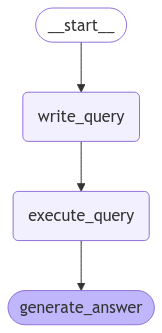

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Save your money don't need to run this
# graph.invoke({"question":"How many no tumor patients are there?"})['answer']

In [11]:
# Function to process the question and get the answer
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

def answer_question():
  question = {'question': input("What is your SQL related question? ")}
  config = {"configurable": {"thread_id": "1"}}

  # Run the graph
  for step in graph.stream(question, config, stream_mode="updates"):
      # print(step)
      pass  # We can pass this to make it neater

  # Retrieve the final state
  try:
    user_approval = input("Do you want to execute query? (yes/no): ")
  except Exception:
    user_approval = "no"

  if user_approval.lower() == "yes":
    for state in graph.stream(None, config, stream_mode="values"):
        pass

    final_output = state.get("answer")
    print(final_output)

  else:
    for state in graph.stream(None, config, stream_mode="values"):
        pass

    generated_query = state.get("query")
    return print(f"Operation cancelled by user. Here is the query: {generated_query}")

In [12]:
# Save your money don't need to run this
# answer_question()

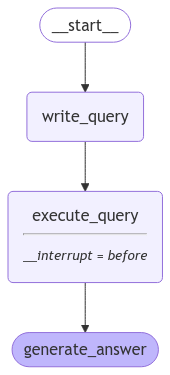

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

# RAG system
## So far we have only handled PDF with only words what if we want to deal with PDF files that are multimedia?

## Preprocessing

In [14]:
# Merge the PDF together
pdf_files = ["cancer1.pdf", "cancer2.pdf"]
merger = PdfMerger()

for pdf in pdf_files:
    merger.append(pdf)

output_path = "merged.pdf"
merger.write(output_path)
merger.close()

In [15]:
# Run this to get the our chunks

'''
chunks = partition_pdf(
    filename='merged.pdf',
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,
)
'''

'\nchunks = partition_pdf(\n    filename=\'merged.pdf\',\n    infer_table_structure=True,            # extract tables\n    strategy="hi_res",                     # mandatory to infer tables\n\n    extract_image_block_types=["Image"],   # Add \'Table\' to list to extract image of tables\n    image_output_dir_path=output_path,   # if None, images and tables will saved in base64\n\n    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage\n\n    chunking_strategy="by_title",          # or \'basic\'\n    max_characters=10000,                  # defaults to 500\n    combine_text_under_n_chars=2000,       # defaults to 0\n    new_after_n_chars=6000,\n)\n'

In [16]:
output_file = "chunks.pkl"

'''
# For saving the chunks to a file
output_file = "chunks.pkl"
with open(output_file, "wb") as file:  # "wb" for write binary
    pickle.dump(chunks, file)

print(f"Chunks saved to {output_file}")
'''

# Load the chunks back
with open(output_file, "rb") as file:  # "rb" for read binary
    chunks = pickle.load(file)

print(f"Chunks loaded successfully. Type of first element: {type(chunks[0])}") # Should see only composite elements

Chunks loaded successfully. Type of first element: <class 'unstructured.documents.elements.CompositeElement'>


## Exploration

In [17]:
# Overview
# pprint(chunks)

# Chunk contents
# pprint(chunks[7].to_dict())

In [18]:
print(len(chunks))

101


In [19]:
# We get 2 types of elements from the partition_pdf function
print(set([str(type(i)) for i in chunks]))

{"<class 'unstructured.documents.elements.CompositeElement'>", "<class 'unstructured.documents.elements.Table'>"}


In [20]:
pprint(chunks[0].to_dict())

{'element_id': '6d90d0c036da84fc0915f35aa50ae6f3',
 'metadata': {'filename': 'merged-min.pdf',
              'filetype': 'application/pdf',
              'languages': ['eng'],
              'last_modified': '2024-12-08T15:25:43',
              'orig_elements': 'eJzVW9tuG0cS/ZWBgAA2oKb6fvGb4wi7BhLHGynJg2IYfRUHS3K4w6FlIdh/3+qeIXVjHInK0NmHOKriNDnTp+vUqeqei9+P4izO46L7WIejV9UR9zJxZjziUTLEg7LIGcaRth5L7gULLBwdV0fz2NlgOwtjfj/yTdOGemG7uCr2zF436+7jNNaX0w48lDEDYwb3VR26KXiJFAy8y6ZedHncxYUkE3JccTbhH46rwZJ6QrIF3zHRD8xyLdhHq+tVF+f5Cd7Xn+PsbGl9PPovfBBiF31XN4uPfmZXq4/LtnFwGZ5ojrmCC1I9i931Mpax7384Kje6uFzby/I0F0dxcXn0oXhX3cd5E+pUxzJXFFOOCEVYnxPxiopXnOXRSxj5cbGeu9jmp8w30cXPeR6OMD0h9CSPO64wf8VUvn7z4/+MNsAQuP4+KNFokxL3SGuWEDdRIMcMRiJ5paPy3mozHihCDqiUiR/MDQ6EcjKRD+1y+Z7AKKPogYF5HdazrnoDU97aWfUutp+a9ao6K/dena/nTbuqzttou4xK9eL9d//6bY2xjS8rVL178/ZxMFJ49IwVoi4pCDCGkTE+IGas5IYYEo0fDUaC+QRWHeFiAKq3KVYTkW1NeA6o+3Z//X5ACkoIPzCQTVu9e33+9sd3r7+v3rx+9+b0p+rtu7Pzt+c/n5/eRum87mZxF0gkYWc5iYjIAASYIkPWwj9Oi+SwI1grNh5IBGdQGM

In [21]:
chunks[7].to_dict()

{'type': 'Table',
 'element_id': 'e6bb6809949ef62adc3a63f80a64f21a',
 'text': 'I II III IV',
 'metadata': {'last_modified': '2024-12-08T15:25:43',
  'text_as_html': '<table><tr><td/><td/><td/><td/><td/></tr></table>',
  'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 7,
  'orig_elements': 'eJyNkMlqwzAQQH/F6FwvkrzEIeSeQyHQ0IsJQrYmtsC2jD2hMSH/XklJe+qhoPVpnjSj6k6ghwFGFFqRbUA2PAcqszpULEnDtIQyrPO8CTe8uWQ8L4uUK/IWkAFQKonSOnfSGDMrPUqExe97uZorig5026EljPPSOi/8pRV2ltI845ZORo/ovKqirIgsopyyqDy/Bb8gTWlEPciSPMr+JE/JIrKsC8LgqjnqG/Qfk2yAPOyBAoQGtRlF08tlEdNsahuWREXBEpfhRfeA6wTePb4Tn/TYXmXrK6sIjC05e7qgGIzSFw3+31jC0pCyMNmcaLZl2Tblzp6sKcbrUMNsowpLEG4o5CI6HHon7lDWPex3WBu12mm2Xe13sRv+s4idEb/s+HmZL9Y95B44BAfXbP90Gf2Ud3KR5HH+Bj6ZljI=',
  'filename': 'merged-min.pdf'}}

In [22]:
# pprint(chunks[3])
pprint(chunks[3].metadata.orig_elements)

print("-------------------------")

# pprint(chunks[3].to_dict())

-------------------------


In [23]:
# Take a sneak peak at the text data
elements = chunks[3].metadata.orig_elements
# print(elements)

chunk_texts = [e for e in elements if 'NarrativeText' in str(type(e))]
# print(chunk_texts)

for text in chunk_texts:
  # pprint(text.metadata)
  pprint(str(text))
  break

('Several genetic alterations have emerged as powerful prognostic factors in '
 'diuse glioma (astrocytoma, oligodendroglioma, mixed glioma, and '
 'glioblastoma), and these alterations may guide patient management. Specic '
 'alterations include the following:')


In [24]:
# Separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

print(len(tables))
print(tables[0:1])
print(tables[0])
print("--------------")
print(len(texts))
print(texts[0:1])

22
I II III IV
--------------
79


In [25]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
  images_b64 = []
  for chunk in chunks:
    if "CompositeElement" in str(type(chunk)):
      chunk_els = chunk.metadata.orig_elements
      for el in chunk_els:
        if "Image" in str(type(el)):
            images_b64.append(el.metadata.image_base64)
  return images_b64

images = get_images_base64(chunks)
pprint(images)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAI9AjwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkJoOe1ee/ELxnqPhvVdLsrOW1hS73b5rn7q4z7UAehDFLXl3hH4m3GoHWjqkcEtppg3Ne2jblk4zgAgc1oL8Y

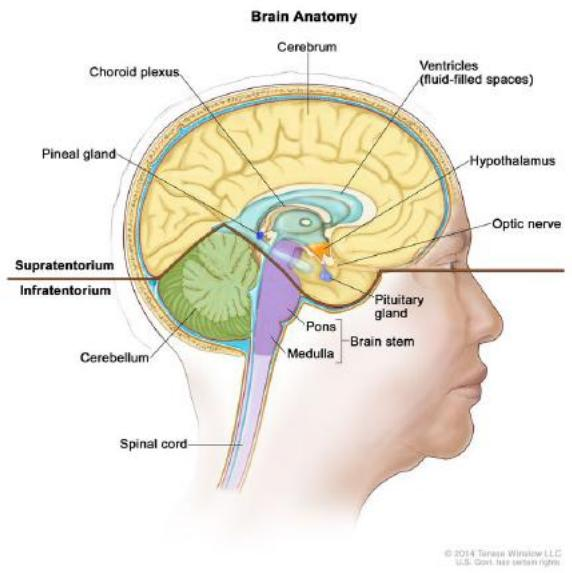

In [26]:
# Decode the base64 string to binary
# Display the image

def display_base64_image(base64_code):
    image_data = base64.b64decode(base64_code)
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarisation

In [27]:
pprint(tables[0].to_dict())
print("--------------")
pprint(texts[0].to_dict())

{'element_id': 'e6bb6809949ef62adc3a63f80a64f21a',
 'metadata': {'filename': 'merged-min.pdf',
              'filetype': 'application/pdf',
              'languages': ['eng'],
              'last_modified': '2024-12-08T15:25:43',
              'orig_elements': 'eJyNkEuLgzAQgP+K5Lw+Eo3aUnrvYaGwZS9SQmxGDagRnbKV0v++Sdrd0x4W8vwyXzKT6k6ghwFGFFqRbUBy1UCS8SaUlKVhRstNWHLVhJBJXkCuFC85eQvIACiVRGmdO7kYMys9SoTF73u5miuKDnTboSUsTTfWeeEvrbCzlOY8tXQyekTnVRVlRWQRTSmLNue34BdkGY2oBzzJI/4neUoWkWVdEAZXzVHfoP+Y5AXIwx4oQLigNqO49HJZxDSb2oYlUVGwxGXY6B5wncC7x3fikx7bq2x9ZRWBsSVnTxcUg1G60eD/jSUsCykLk/JE+ZbxbZY6e7KmGK9DDbONKixBuKGQi+hw6J24Q1n3sN9hbdRqp9l2td/FbvjPInZG/LLj52W+WPeQe+AQHFyz/dNl9FPeyUWSx/kb86iWkw==',
              'page_number': 7,
              'text_as_html': '<table><tr><td/><td/><td/><td/><td/></tr></table>'},
 'text': 'I II III IV',
 'type': 'Table'}
--------------
{'element_id': '6d90d0c036da84fc0915f35aa50ae6f3',
 'metadata': {'filename': 'merged-min.pdf',
              'filetype': 'application/

In [28]:
# Text summariser
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = {"element": lambda x: x} | prompt | gpt | StrOutputParser()

# Summarize text, concurrency limits the number of task running at the same time
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

In [29]:
pprint(texts[0].text)

('02/12/2024, 04:37\n'
 '\n'
 'Adult Central Nervous System Tumors Treatment (PDQ®) - NCI\n'
 '\n'
 'or NATIONAL CANCER INSTITUTE\n'
 '\n'
 'Adult Central Nervous System Tumors Treatment (PDQ®)–Health Professional '
 'Version\n'
 '\n'
 'Go to Patient Version\n'
 '\n'
 'General Information About Adult Central Nervous System\n'
 '\n'
 '(CNS) Tumors\n'
 '\n'
 'Incidence and Mortality\n'
 '\n'
 'Brain tumors account for 85% to 90% of all primary central nervous system '
 '(CNS) tumors.[1] Estimated new cases and deaths from brain tumors and other '
 'nervous system tumors in the United States in 2024:[2]\n'
 '\n'
 '• New cases: 25,400.\n'
 '\n'
 '• Deaths: 18,760.\n'
 '\n'
 'Data from the Surveillance, Epidemiology, and End Results (SEER) Program '
 'database for 2016 to 2020 indicated that the combined incidence of brain and '
 'other CNS tumors in the United States was 6.2 per 100,000 people per year, '
 'and the mortality rate was 4.4 deaths per 100,000 people per year.[3] '
 'Worldwide

In [30]:
pprint(text_summaries[0])

('In the United States in 2024, there are an estimated 25,400 new cases and '
 '18,760 deaths from brain and other central nervous system (CNS) tumors. The '
 'incidence rate from 2016 to 2020 was 6.2 per 100,000 people per year, with a '
 'mortality rate of 4.4 per 100,000 people per year. Globally, in 2020, there '
 'were approximately 308,102 new cases and 251,329 deaths from these tumors. '
 'Primary CNS tumors occur more frequently in White individuals than in Black '
 'individuals and are more lethal in men than in women. The most common '
 'primary brain tumors are anaplastic astrocytomas, glioblastomas, and '
 'meningiomas, while primary spinal tumors mainly include schwannomas, '
 'meningiomas, and ependymomas. Primary brain tumors typically do not spread '
 'outside the CNS but can spread within it.')


In [31]:
# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [32]:
pprint(table_summaries[0])

'The table is empty, containing only empty cells arranged in a single row.'


In [33]:
# Image summariser
prompt_template = """
  Describe the image in detail. For context,
  the image is part of a research paper explaining the meidcal treatment
  of brain cancer. Be specific about graphs such as bar plots if any
  or diagrams showing the human anatomy.
"""

messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | gpt | StrOutputParser()


image_summaries = chain.batch(images)
pprint(image_summaries[0])

('The image is a detailed illustration of human brain anatomy, presented in a '
 'side view (sagittal section) of the head. It labels various parts of the '
 'brain and some associated structures, providing a clear educational overview '
 'suitable for understanding basic brain anatomy, which could be relevant in '
 'the context of discussing brain cancer treatment.\n'
 '\n'
 'Key features labeled in the image include:\n'
 '\n'
 '1. **Cerebrum**: The largest part of the brain, shown in yellow, occupying '
 'the upper part of the image.\n'
 '2. **Cerebellum**: Located at the back of the brain beneath the cerebrum, '
 'shown in green.\n'
 '3. **Brain stem**: Comprising the midbrain, pons, and medulla, shown in '
 'purple and blue, extending downwards.\n'
 '4. **Spinal cord**: Extends from the brain stem down out of the skull.\n'
 '5. **Pituitary gland**: A small, pea-sized gland shown in light blue, '
 'located just beneath the hypothalamus.\n'
 '6. **Hypothalamus**: Above the pituitary 

In [ ]:
# Set up persistence directory for Chroma
persist_directory = "/content/db"

# The vectorstore to use to index the chunks
vectorstore = Chroma(
    collection_name="multi_modal_rag",
    embedding_function=embeddings,
    client_settings=Settings(persist_directory=persist_directory)
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [37]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
# print(doc_ids[0:2])

summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]

retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

In [38]:
results = retriever.invoke("How to treat meningioma?")
results[0].to_dict()

{'type': 'CompositeElement',
 'element_id': 'b9e35424416e4646d4ebb9724d232b62',
 'text': 'https://www.cancer.gov/types/brain/hp/adult-brain-treatment-pdq\n\nhttps://www.cancer.gov/types/brain/hp/adult-brain-treatment-pdq\n\n35/54\n\n02/12/2024, 04:37\n\nAdult Central Nervous System Tumors Treatment (PDQ®) - NCI\n\nThe prognoses for patients with WHO grade II meningiomas (atypical, clear cell, and chordoid), WHO grade III meningiomas (anaplastic/malignant, rhabdoid, and papillary), and hemangiopericytomas are worse than the prognoses for patients with low-grade meningiomas because complete resections are less commonly feasible, and the proliferative capacity is greater.\n\nTreatment options for grades II and III meningiomas and hemangiopericytomas include the following:\n\n1. Surgery plus radiation therapy.\n\nGerm Cell Tumors Treatment\n\nThe prognoses and treatment of patients with germ cell tumors—which include germinomas, embryonal carcinomas, choriocarcinomas, and teratomas—depend 

In [39]:
# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [41]:
# Retrieve
docs = retriever.invoke("Show me a picture of the brain")

In [ ]:
def display_base64_image(base64_code):
  image_data = base64.b64decode(base64_code)
  display(Image(data=image_data))

for i in range(0,4):
  display_base64_image(docs[i])

## Chaining

In [50]:
# Creating the image and text answer
def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}

# Testing
pprint(parse_docs(docs))

# Testing
pprint(parse_docs(results))

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAI9AjwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkJoOe1ee/ELxnqPhvVdLsrOW1hS73b5rn7q4z7UAehDFLXl3hH4m3GoHWjqkcEtppg3Ne2jblk

In [57]:
def build_prompt(kwargs):
  docs_by_type = kwargs["context"]
  user_question = kwargs["question"]

  context_text = ""
  if len(docs_by_type["texts"]) > 0:
      for text_element in docs_by_type["texts"]:
          context_text += text_element.text

  # construct prompt with context (including images)
  prompt_template = f"""
  Answer the question to the best of your abilities based only on the following
  context, which can include text, tables, and the image below.
  Context: {context_text}
  Question: {user_question}
  """

  prompt_content = [{"type": "text", "text": prompt_template}]

  if len(docs_by_type["images"]) > 0:
      for image in docs_by_type["images"]:
          prompt_content.append(
              {
                  "type": "image_url",
                  "image_url": {"url": f"data:image/jpeg;base64,{image}"},
              }
          )

  return ChatPromptTemplate.from_messages([HumanMessage(content=prompt_content),])

In [58]:
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt) | gpt | StrOutputParser()
)

In [59]:
print(chain.invoke("How to treat meningioma?"))

The treatment of meningioma depends on the grade of the tumor, its location, size, and whether it is causing symptoms. Here are the general treatment options based on the grade of meningioma:

1. **Grade I Meningiomas**:
   - **Active Surveillance with Deferred Treatment**: This approach is often suitable for small, asymptomatic tumors that are incidentally discovered. Regular monitoring through imaging studies is conducted to track any changes in the tumor's size or behavior.
   - **Surgery**: If the tumor is causing symptoms or shows signs of growth, surgical removal is typically recommended. Complete resection can often be curative.
   - **Stereotactic Radiosurgery**: This is an option for smaller tumors (less than 3 cm) and is a non-invasive treatment that uses focused radiation beams to target the tumor.
   - **Fractionated Radiation Therapy**: This may be used for patients with unresectable tumors or when complete surgical removal isn't possible.

2. **Grades II and III Meningiom

In [61]:
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(RunnableLambda(build_prompt) | gpt | StrOutputParser())
)

In [62]:
response = chain_with_sources.invoke("Can you show a picture of the brain")

pprint(response)

{'context': {'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAI9AjwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkJoOe1ee/ELxnqPhvVdLsrOW1hS73b5rn7q4z7UAehDFLXl3hH4m3GoHWjqkcE

In [ ]:
# response = chain_with_sources.invoke("Show me a picture of the brain")
# response = chain_with_sources.invoke("Show me a picture of craniotomy")
# response = chain_with_sources.invoke("How to treat meningioma")

if response['context']['images'] is not None:
  for image in response['context']['images']:
      display_base64_image(image)
else:
  print("Response:", response['response'])


print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: The first image in the set you provided shows a detailed illustration of the brain anatomy within a human head profile. This image effectively depicts various parts of the brain such as the cerebrum, cerebellum, brain stem (including the pons and medulla), and other components like the pituitary gland, hypothalamus, and the ventricles (fluid-filled spaces). This illustration is a clear and educational representation of the brain's structure and its location within the head.


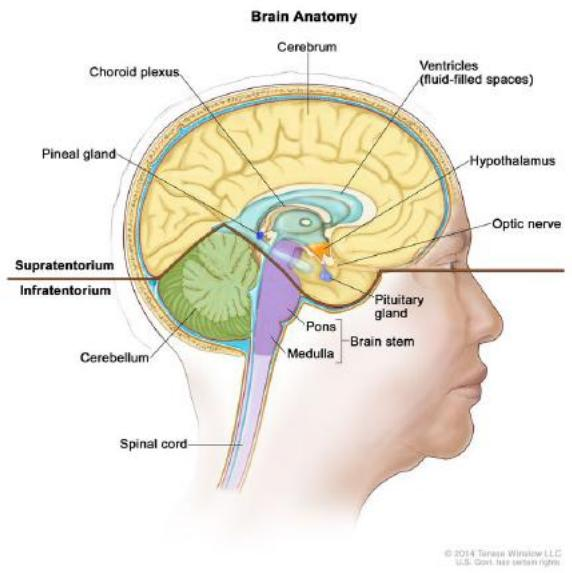

In [64]:
if response['context']['images'] is not None:
  print("Response:", response['response'])
  display_base64_image(response['context']['images'][0])
else:
  print("Response:", response['response'])

The first image in the set you provided shows a detailed illustration of the brain anatomy within a human head profile. This image effectively depicts various parts of the brain such as the cerebrum, cerebellum, brain stem (including the pons and medulla), and other components like the pituitary gland, hypothalamus, and the ventricles (fluid-filled spaces). This illustration is a clear and educational representation of the brain's structure and its location within the head.


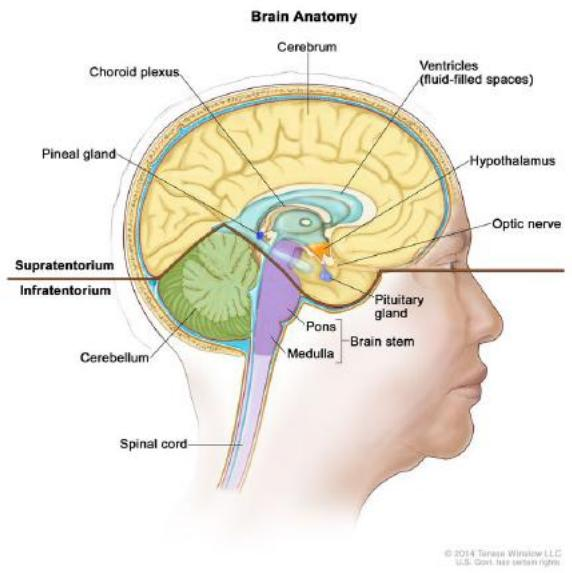

In [65]:
source = chain_with_sources.invoke("Show me a picture of the brain")
print(response['response'])

display_base64_image(source['context']['images'][0])

## Rag langgraph

Image 1:


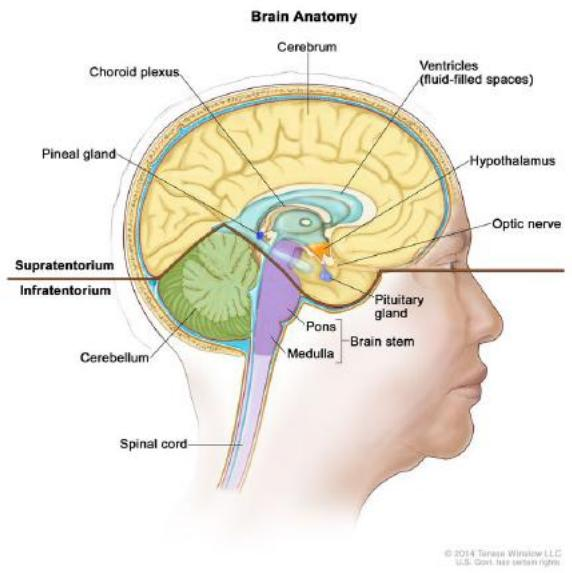

Image 2:


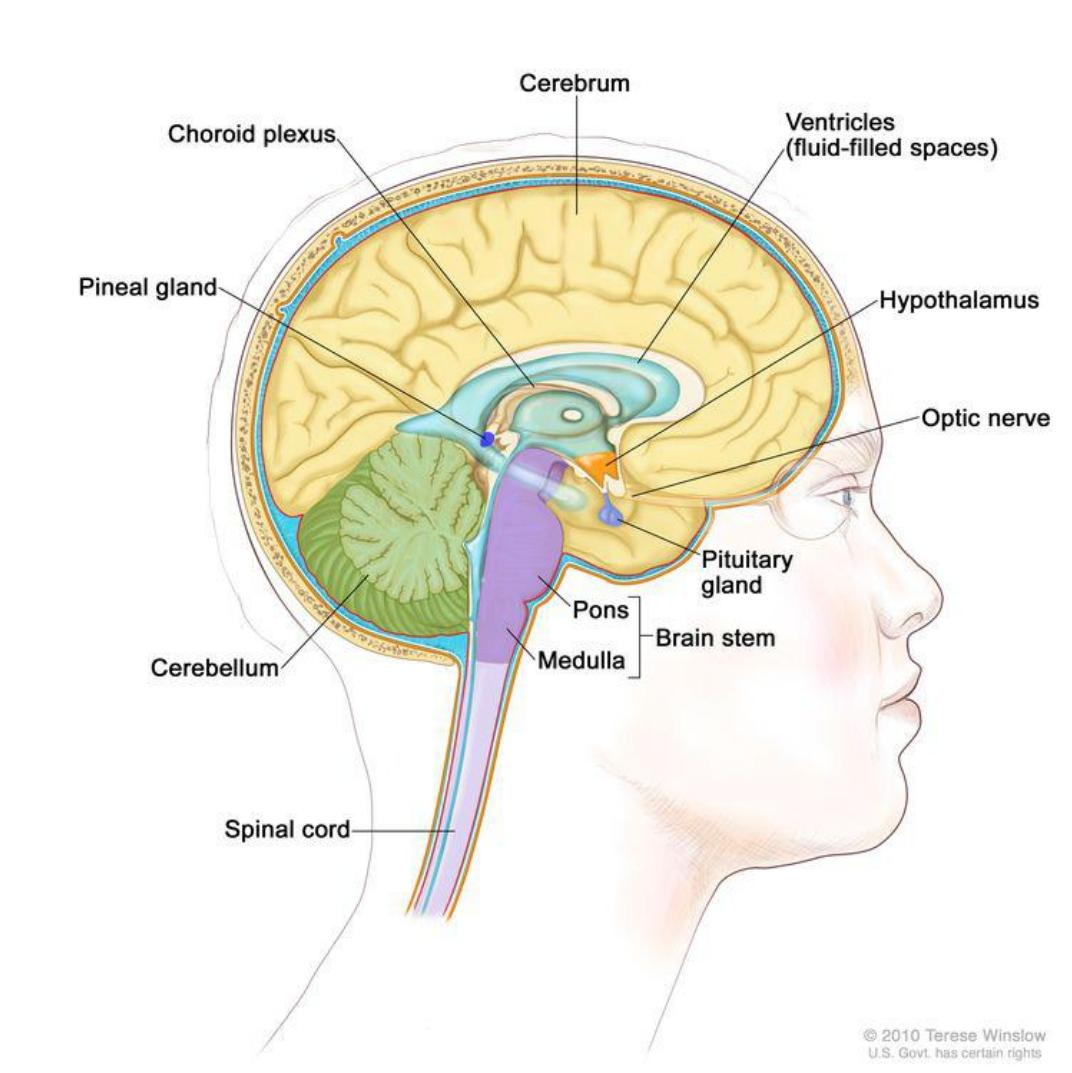

Image 3:


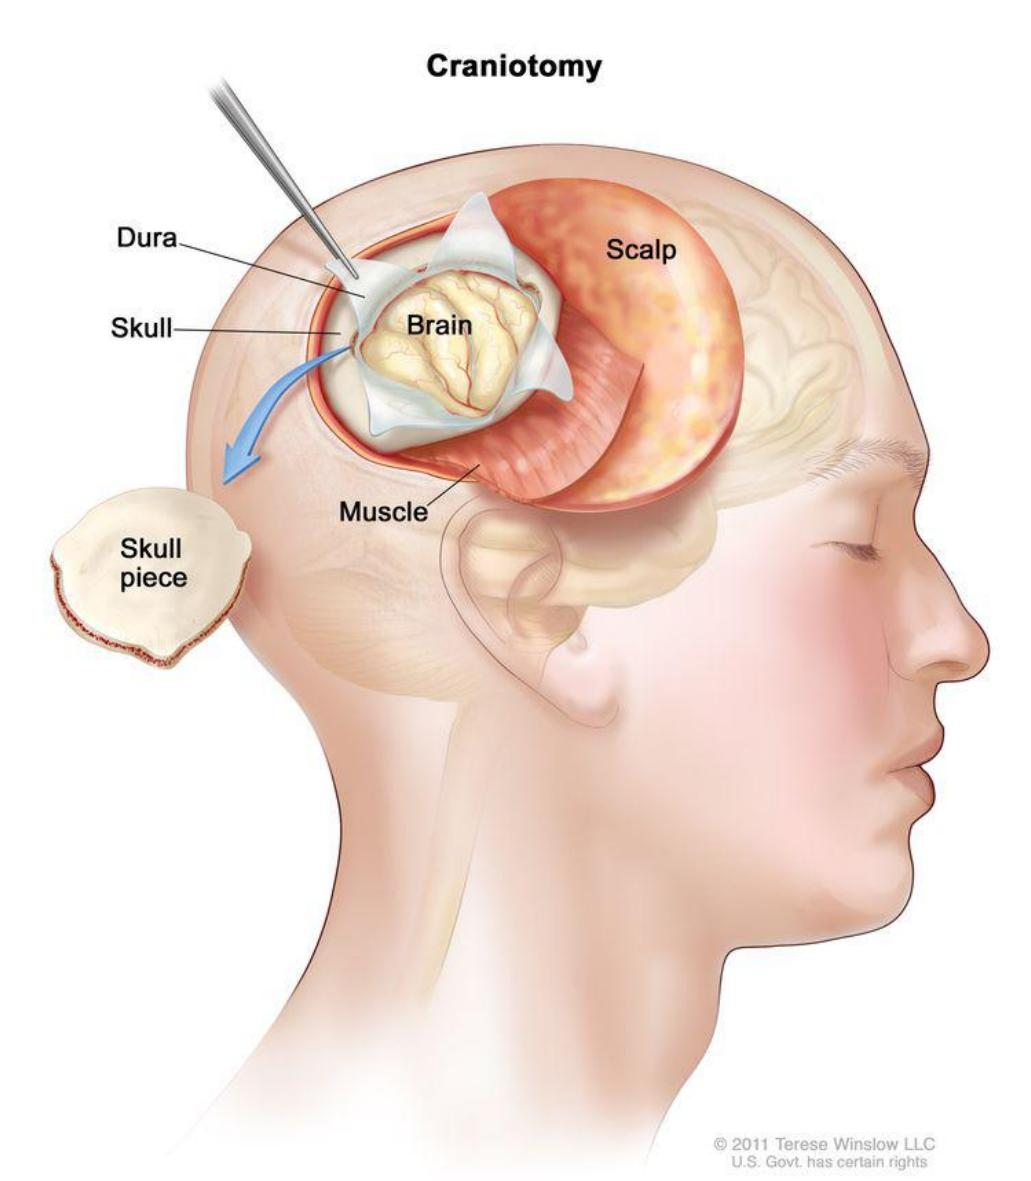

Image 4:


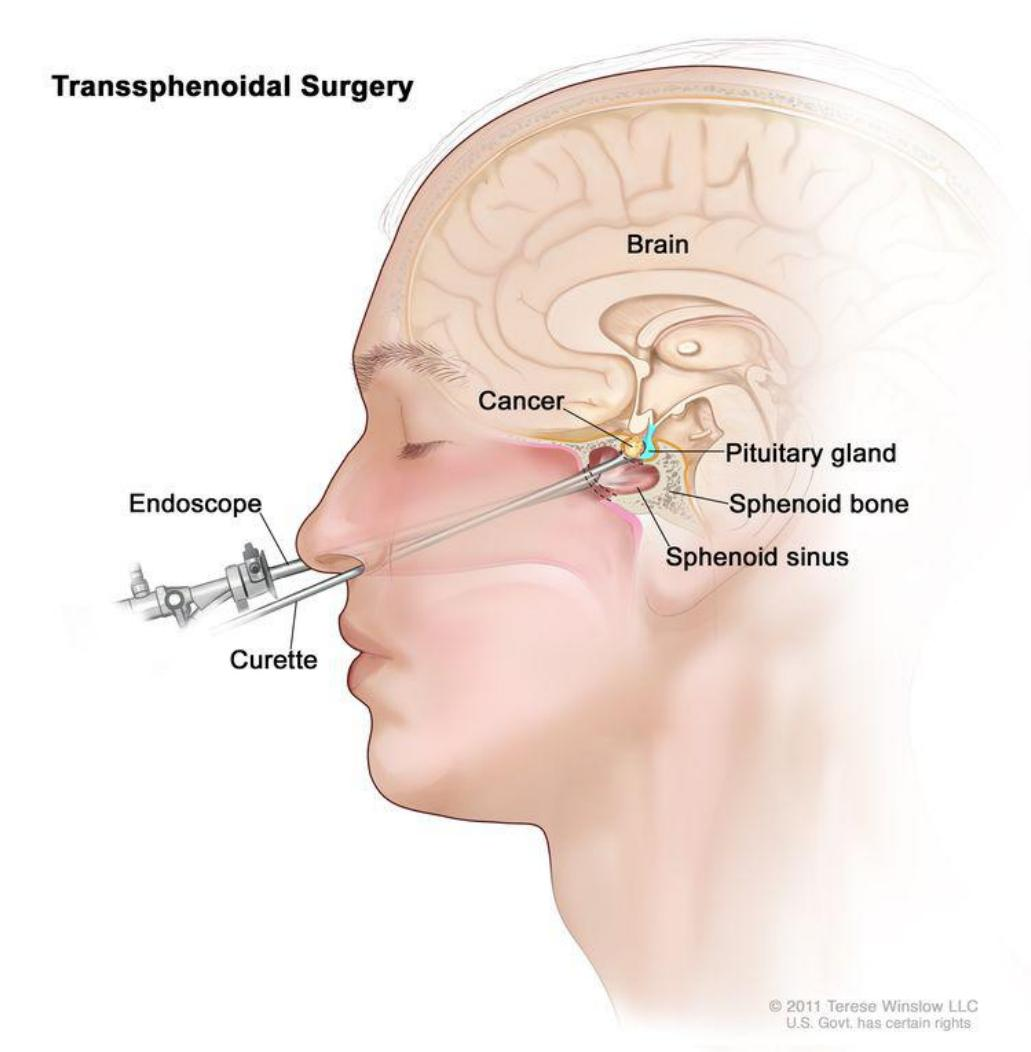

In [66]:
from typing import TypedDict, List, Dict, Any
from langgraph.graph.state import StateGraph, START

class RagState(TypedDict):
    """Represents the state of our graph."""
    question: str
    response: str
    images: List[str]

def generation(state: RagState):
    """Generate a response using the chain_with_sources."""
    question = state["question"]

    response = chain_with_sources.invoke(question)

    text = response.get('response', "No response generated")

    images = response.get('context', {}).get('images', [])
    images = images if images else "No diagrams"

    return {
        "response": text,
        "images": images,
    }

def showcase_answers(state: RagState):
    """Showcase all answers, including the response and images."""
    # print("Generated Response:")
    # print(state["response"])

    if state["images"]:
        for i, image in enumerate(state["images"]):
            print(f"Image {i + 1}:")
            display_base64_image(image)
    else:
        print("No diagrams available.")

    return state

rag_graph = StateGraph(RagState)
rag_graph.add_sequence([generation, showcase_answers])
rag_graph.add_edge(START, "generation")

memory = MemorySaver()
rag = rag_graph.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "1"}}

result = rag.invoke({"question": "Can you show a picture of the brain?"}, config)

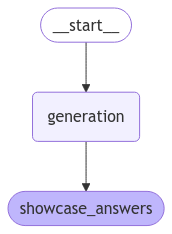

In [67]:
display(Image(rag.get_graph(xray=True).draw_mermaid_png()))

# Parent Graph


## New SQL graph

In [68]:
# LangGraph create our workflow!
class SqlState(TypedDict):
    question: str
    query: str
    result: str
    answer: str

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

# Make sure we only have one message
assert len(query_prompt_template.messages) == 1

# query_prompt_template.messages[0].pretty_print()

# Create our personalised pydantic model
class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

def write_query(state: SqlState):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 5,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = gpt.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

# print(write_query({"question": "How many rows are there?"}))

def execute_query(state: SqlState):
    """Execute SQL query"""
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

# print(execute_query(write_query({"question": "How many Employees are there?"})))

def generate_answer(state: SqlState):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = gpt.invoke(prompt)
    return {"answer": response.content}

sql_builder = StateGraph(SqlState).add_sequence(
  [write_query, execute_query, generate_answer]
)

memory = MemorySaver()
sql_builder.add_edge(START, "write_query")
sql = sql_builder.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "1"}}

print(sql.invoke({"question": "How many patients are there?"}, config))

{'question': 'How many patients are there?', 'query': 'SELECT COUNT(DISTINCT image_hash) AS patient_count FROM mri_data;', 'result': '[(6726,)]', 'answer': 'The number of patients is 6726.'}


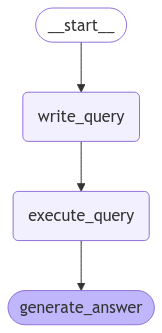

In [69]:
display(Image(sql.get_graph(xray=True).draw_mermaid_png()))

## New RAG Graph

In [70]:
class RagState(TypedDict):
    """Represents the state of our graph."""
    question: str
    answer: str
    images: List[str]

def generation(state: RagState):
    """Generate a response using the chain_with_sources."""
    question = state["question"]

    response = chain_with_sources.invoke(question)

    text = response.get('response', "No response generated")

    images = response.get('context', {}).get('images', [])
    images = images if images else "No diagrams"

    return {
        "answer": text,
        "images": images,
    }

rag_graph = StateGraph(RagState)
rag_graph.add_sequence([generation])
rag_graph.add_edge(START, "generation")

memory = MemorySaver()
rag = rag_graph.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "1"}}

result = rag.invoke({"question": "Can you show a picture of the brain?"}, config)
result['images']

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAI9AjwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkJoOe1ee/ELxnqPhvVdLsrOW1hS73b5rn7q4z7UAehDFLXl3hH4m3GoHWjqkcEtppg3Ne2jblk4zgAgc1oL8Y

## Final Graph

In [72]:
from typing import TypedDict
from langgraph.graph.state import StateGraph, START

class ParentGraph(TypedDict):
  """Represents the state of our graph."""
  question: str
  question_type: str
  answer: str
  images: List[str]

def classify_question(state: ParentGraph):
  """Identify the type of question."""
  question = state["question"]

  classification_prompt = f"""
  You are a classifier. Determine the appropriate category for the following question:
  - "SQL" if the question is related to SQL queries, databases, retrieving structured data, or performing data analysis using SQL or relational database concepts.
  - "RAG" if the question involves retrieving information from external documents, combining data from multiple sources, or problem-solving using Retrieval-Augmented Generation (RAG) techniques.

  Question: {question}
  Answer with only "SQL" or "RAG".
  """

  question_type = gpt.invoke(classification_prompt).content.strip()

  return {"question_type": question_type, "question": question}

# print(classify_question({"question":"How many people are there?"}))

def sql_subgraph(state: ParentGraph):
  """SQL-specific subgraph."""
  question = state["question"]

  response = sql.invoke({"question": question}, config)
  return {"answer": response["answer"]}

# print(sql_subgraph(question_type({"question":"How many people are there?"})))

def rag_subgraph(state: ParentGraph):
  """RAG-specific subgraph."""
  question = state["question"]

  response = rag.invoke({"question": question}, config)

  answer = response.get("answer", "No response available.")
  images = response.get("images", [])

  return {"answer": answer, "images": images}

# print(rag_subgraph(question_type({"question":"Show me a picture of the brain"})))
# print(rag_subgraph(question_type({"question":"Show me a picture of the brain"}))['images'])

def route_based_on_question_type(state: ParentGraph):
  if state["question_type"] == "SQL":
      return "sql_subgraph"
  elif state["question_type"] == "RAG":
      return "rag_subgraph"
  else:
      return END

{'question_type': 'RAG', 'question': 'How many people are there?'}


In [80]:
# Define the parent graph
parent_graph = StateGraph(ParentGraph)

parent_graph.add_node("classify_question", classify_question)
parent_graph.add_node("sql_subgraph", sql_subgraph)
parent_graph.add_node("rag_subgraph", rag_subgraph)

# Add conditional edges based on the routing function
parent_graph.add_conditional_edges("classify_question", route_based_on_question_type)

parent_graph.add_edge(START, "classify_question")

# memory = MemorySaver()
# parent = parent_graph.compile(checkpointer=memory)
# config = {"configurable": {"thread_id": "1"}}

parent = parent_graph.compile()

result = parent.invoke({"question": "How many people are there?"})
# result = parent.invoke({"question": "Show me a picture of the brain"})

# print("Final Answer:", result["answer"])
print("Final Answer:", result)

Final Answer: {'question': 'How many people are there?', 'question_type': 'RAG', 'answer': 'There are no people in the image you provided. The image displays a comparison of various tumor sizes to common objects like fruits and nuts to help visualize their dimensions.', 'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCALqBDADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g

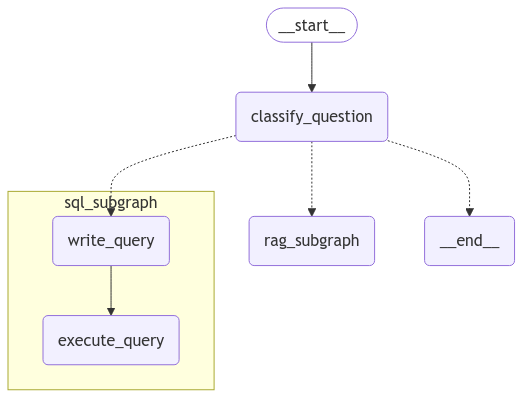

In [81]:
display(Image(parent.get_graph(xray=True).draw_mermaid_png(), width=1000))

## Gradio UI

In [95]:
import tempfile
import base64
import os

def process_question(user_input):
  result = parent.invoke({"question": user_input})
  answer_text = result["answer"]
  images = result.get("images")

  temp_image_paths = []

  if (
    images
    and len(images) > 0 # Cannot be empty
    and images[0].startswith('/9j/4AAQ') # Must be base64
    and images[0] != 'No diagrams' # Or we can use this to solve everything
  ):
    for idx, img_data in enumerate(images):
        img_data = img_data.split(',')[1] if ',' in img_data else img_data
        img_bytes = base64.b64decode(img_data)
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg")
        temp_file.write(img_bytes)
        temp_file.close()
        temp_image_paths.append(temp_file.name)

  return answer_text, temp_image_paths

# process_question("Show me a picture of the brain")
# process_question("How many patients are there")
# process_question("Can you give me a breakdown of the number of people with the different type of cancers?")
# process_question("How many patients are there with no tumors detected?")

('There are 1731 patients with no tumors detected.', [])

In [ ]:
# Create a Gradio interface with a custom layout

banner_url = "https://i.imgur.com/jn2wz20.png"

with gr.Blocks() as iface:
    # Add the banner image
    gr.Markdown(f"""
    <div style="text-align: center; margin-bottom: 20px;">
        <img src="{banner_url}" alt="Doctor Banner" style="max-width: 100%; height: auto;">
    </div>
    """)

    # Add the title and description
    gr.Markdown("""
    ## Doctor's Question & Answering System
    Enter a question, and the system will classify and process it accordingly. If applicable, images will also be displayed.
    """)

    # Add the input and outputs
    with gr.Row():
        question_input = gr.Textbox(
            label="Ask Your Question", lines=2, placeholder="Enter your question here..."
        )
    with gr.Row():
        answer_output = gr.Textbox(label="Answer", lines=8)
        images_output = gr.Gallery(label="Images", show_label=True)

    # Add the submit button
    submit_btn = gr.Button("Submit")
    submit_btn.click(
        fn=process_question,
        inputs=question_input,
        outputs=[answer_output, images_output]
    )

# Launch the Gradio app
if __name__ == "__main__":
    iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ce18ea5c98bb141e59.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
